In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,GroupShuffleSplit
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import warnings
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from datetime import datetime
import seaborn as sns
from scipy.stats import skew, kurtosis
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import optuna
import joblib
import numpy as np
from sklearn.model_selection import KFold
warnings.filterwarnings("ignore")


2025-10-15 03:16:53.988690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760498214.315391     196 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760498214.404999     196 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ============================================================================
# GPU CONFIGURATION & OPTIMIZATION
# ============================================================================

def setup_gpu():
    """Configure GPU for optimal performance"""
    print("="*80)
    print("GPU CONFIGURATION")
    print("="*80)
    
    # Check available GPUs
    gpus = tf.config.list_physical_devices('GPU')
    print(f"\n🖥️  Available GPUs: {len(gpus)}")
    
    if gpus:
        try:
            # Enable memory growth (don't allocate all GPU memory at once)
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                print(f"   ✓ GPU: {gpu.name} - Memory growth enabled")
            
            # Set GPU memory limit (optional - useful if sharing GPU)
            # tf.config.set_logical_device_configuration(
            #     gpus[0],
            #     [tf.config.LogicalDeviceConfiguration(memory_limit=4096)]  # 4GB
            # )
            
            # Use mixed precision for faster training
            policy = tf.keras.mixed_precision.Policy('mixed_float16')
            tf.keras.mixed_precision.set_global_policy(policy)
            print(f"   ✓ Mixed precision enabled: {policy.name}")
            
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(f"   ✓ Logical GPUs: {len(logical_gpus)}")
            
        except RuntimeError as e:
            print(f"   ⚠️  GPU configuration error: {e}")
    else:
        print("   ⚠️  No GPU found - using CPU (training will be slower)")
    
    # Set TensorFlow options for better performance
    tf.config.optimizer.set_jit(True)  # XLA compilation
    print("   ✓ XLA (Accelerated Linear Algebra) enabled")
    
    print(f"\n📊 TensorFlow version: {tf.__version__}")
    print(f"📊 Keras version: {keras.__version__}")
    
    return len(gpus) > 0

# ============================================================================
# CONFIGURATION
# ============================================================================

CONFIG = {
    'sequence_length': 10,
    'max_frames_to_predict': 15,
    'batch_size': 256,  # Larger batch for GPU
    'epochs': 100,
    'learning_rate': 0.001,
    'validation_split': 0.15,
    'use_gpu': True,
}

# ============================================================================
# EVALUATION METRICS
# ============================================================================

def calculate_rmse(y_true, y_pred):
    """Calculate Root Mean Squared Error"""
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def calculate_mae(y_true, y_pred):
    """Calculate Mean Absolute Error"""
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

def calculate_euclidean_distance(y_true, y_pred):
    """Calculate Euclidean distance between predicted and actual positions"""
    distances = np.sqrt((y_true[:, 0] - y_pred[:, 0])**2 + 
                       (y_true[:, 1] - y_pred[:, 1])**2)
    return distances

def evaluate_predictions(y_true, y_pred, split_name="Validation"):
    """Comprehensive evaluation of predictions"""
    print("\n" + "="*80)
    print(f"📊 {split_name.upper()} SET EVALUATION")
    print("="*80)
    
    # Overall metrics
    x_rmse = calculate_rmse(y_true[:, 0], y_pred[:, 0])
    y_rmse = calculate_rmse(y_true[:, 1], y_pred[:, 1])
    
    x_mae = calculate_mae(y_true[:, 0], y_pred[:, 0])
    y_mae = calculate_mae(y_true[:, 1], y_pred[:, 1])
    
    # Euclidean distance
    distances = calculate_euclidean_distance(y_true, y_pred)
    mean_distance = np.mean(distances)
    median_distance = np.median(distances)
    
    print(f"\n🎯 POSITION ACCURACY:")
    print(f"   X-coordinate:")
    print(f"      RMSE: {x_rmse:.3f} yards")
    print(f"      MAE:  {x_mae:.3f} yards")
    
    print(f"\n   Y-coordinate:")
    print(f"      RMSE: {y_rmse:.3f} yards")
    print(f"      MAE:  {y_mae:.3f} yards")
    
    print(f"\n📏 EUCLIDEAN DISTANCE:")
    print(f"   Mean:   {mean_distance:.3f} yards")
    print(f"   Median: {median_distance:.3f} yards")
    print(f"   Std:    {np.std(distances):.3f} yards")
    print(f"   Min:    {np.min(distances):.3f} yards")
    print(f"   Max:    {np.max(distances):.3f} yards")
    
    # Percentiles
    print(f"\n📊 DISTANCE PERCENTILES:")
    for p in [25, 50, 75, 90, 95, 99]:
        print(f"   {p}th percentile: {np.percentile(distances, p):.3f} yards")
    
    # Accuracy buckets
    print(f"\n🎯 ACCURACY BUCKETS:")
    for threshold in [1, 2, 5, 10, 15, 20]:
        within = (distances <= threshold).sum()
        pct = 100 * within / len(distances)
        print(f"   Within {threshold:2d} yards: {within:6,} ({pct:5.2f}%)")
    
    metrics = {
        'x_rmse': x_rmse,
        'y_rmse': y_rmse,
        'x_mae': x_mae,
        'y_mae': y_mae,
        'mean_distance': mean_distance,
        'median_distance': median_distance,
        'distances': distances
    }
    
    return metrics

def plot_predictions(y_true, y_pred, split_name="Validation", save_path="predictions_plot.png"):
    """Visualize predictions vs actual"""
    
    fig = plt.figure(figsize=(20, 12))
    
    # 1. X predictions scatter
    ax1 = plt.subplot(2, 3, 1)
    ax1.scatter(y_true[:, 0], y_pred[:, 0], alpha=0.3, s=1)
    ax1.plot([0, 120], [0, 120], 'r--', linewidth=2)
    ax1.set_xlabel('Actual X (yards)', fontsize=12)
    ax1.set_ylabel('Predicted X (yards)', fontsize=12)
    ax1.set_title(f'{split_name} - X Coordinate', fontsize=14, fontweight='bold')
    ax1.grid(alpha=0.3)
    
    # 2. Y predictions scatter
    ax2 = plt.subplot(2, 3, 2)
    ax2.scatter(y_true[:, 1], y_pred[:, 1], alpha=0.3, s=1)
    ax2.plot([0, 53.3], [0, 53.3], 'r--', linewidth=2)
    ax2.set_xlabel('Actual Y (yards)', fontsize=12)
    ax2.set_ylabel('Predicted Y (yards)', fontsize=12)
    ax2.set_title(f'{split_name} - Y Coordinate', fontsize=14, fontweight='bold')
    ax2.grid(alpha=0.3)
    
    # 3. Error distribution
    ax3 = plt.subplot(2, 3, 3)
    distances = calculate_euclidean_distance(y_true, y_pred)
    ax3.hist(distances, bins=50, alpha=0.7, edgecolor='black')
    ax3.axvline(np.mean(distances), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {np.mean(distances):.2f}')
    ax3.set_xlabel('Euclidean Distance Error (yards)', fontsize=12)
    ax3.set_ylabel('Frequency', fontsize=12)
    ax3.set_title('Prediction Error Distribution', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(alpha=0.3)
    
    # 4. X error distribution
    ax4 = plt.subplot(2, 3, 4)
    x_errors = y_true[:, 0] - y_pred[:, 0]
    ax4.hist(x_errors, bins=50, alpha=0.7, edgecolor='black', color='green')
    ax4.axvline(0, color='red', linestyle='--', linewidth=2)
    ax4.set_xlabel('X Error (yards)', fontsize=12)
    ax4.set_ylabel('Frequency', fontsize=12)
    ax4.set_title(f'X Error - Mean: {np.mean(x_errors):.3f}', fontsize=14, fontweight='bold')
    ax4.grid(alpha=0.3)
    
    # 5. Y error distribution
    ax5 = plt.subplot(2, 3, 5)
    y_errors = y_true[:, 1] - y_pred[:, 1]
    ax5.hist(y_errors, bins=50, alpha=0.7, edgecolor='black', color='orange')
    ax5.axvline(0, color='red', linestyle='--', linewidth=2)
    ax5.set_xlabel('Y Error (yards)', fontsize=12)
    ax5.set_ylabel('Frequency', fontsize=12)
    ax5.set_title(f'Y Error - Mean: {np.mean(y_errors):.3f}', fontsize=14, fontweight='bold')
    ax5.grid(alpha=0.3)
    
    # 6. Cumulative accuracy
    ax6 = plt.subplot(2, 3, 6)
    sorted_distances = np.sort(distances)
    cumulative = np.arange(1, len(sorted_distances) + 1) / len(sorted_distances) * 100
    ax6.plot(sorted_distances, cumulative, linewidth=2)
    ax6.set_xlabel('Distance Threshold (yards)', fontsize=12)
    ax6.set_ylabel('Cumulative % of Predictions', fontsize=12)
    ax6.set_title('Cumulative Accuracy Curve', fontsize=14, fontweight='bold')
    ax6.grid(alpha=0.3)
    
    # Add benchmarks
    for threshold in [5, 10, 15]:
        pct = (distances <= threshold).sum() / len(distances) * 100
        ax6.axvline(threshold, linestyle='--', alpha=0.5)
        ax6.text(threshold, pct, f'{pct:.1f}%', fontsize=10)
    
    plt.suptitle(f'{split_name} Set - Prediction Analysis', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"\n✓ Saved plot: {save_path}")
    
    return fig

def plot_training_history(history, save_path="training_history.png"):
    """Plot training history"""
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Loss plot
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss (MSE)', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # MAE plot
    axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
    axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('MAE (yards)', fontsize=12)
    axes[1].set_title('Training and Validation MAE', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"✓ Saved plot: {save_path}")
    
    return fig

# ============================================================================
# IMPORT FUNCTIONS FROM ORIGINAL CODE
# ============================================================================

def parse_height(height_str):
    if pd.isna(height_str):
        return np.nan
    try:
        feet, inches = map(int, str(height_str).split('-'))
        return feet * 12 + inches
    except:
        return np.nan

def calculate_age(birth_date, reference_date='2023-09-01'):
    try:
        birth = pd.to_datetime(birth_date)
        ref = pd.to_datetime(reference_date)
        return (ref - birth).days / 365.25
    except:
        return np.nan

def load_training_data(data_path='/kaggle/input/nfl-big-data-bowl-2026-prediction/train'):
    print("\n" + "="*80)
    print("LOADING TRAINING DATA")
    print("="*80)
    
    all_data = []
    for week in range(1, 19):
        file_path = f'{data_path}/input_2023_w{week:02d}.csv'
        try:
            df = pd.read_csv(file_path)
            all_data.append(df)
            print(f"✓ Week {week:02d}: {len(df):,} rows | {df['play_id'].nunique():,} plays")
        except FileNotFoundError:
            print(f"✗ Week {week:02d}: File not found")
    
    train_df = pd.concat(all_data, ignore_index=True)
    print(f"\nTotal training data: {len(train_df):,} rows")
    print(f" Unique plays: {(train_df['game_id'].astype(str) + '_' + train_df['play_id'].astype(str)).nunique():,}")
    print(f"Players to predict: {train_df['player_to_predict'].sum():,}")
    
    return train_df

def load_test_data():
    print("\n" + "="*80)
    print("LOADING TEST DATA")
    print("="*80)
    
    test_input = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2026-prediction/test_input.csv')
    test_targets = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2026-prediction/test.csv')
    
    print(f"✓ Test input: {len(test_input):,} rows")
    print(f"✓ Test targets: {len(test_targets):,} predictions needed")
    
    return test_input, test_targets

def normalize_play_direction(df):
    df = df.copy()
    left_mask = df['play_direction'] == 'left'
    num_flipped = left_mask.sum()
    
    df.loc[left_mask, 'x'] = 120 - df.loc[left_mask, 'x']
    df.loc[left_mask, 'y'] = 53.3 - df.loc[left_mask, 'y']
    df.loc[left_mask, 'dir'] = (df.loc[left_mask, 'dir'] + 180) % 360
    df.loc[left_mask, 'o'] = (df.loc[left_mask, 'o'] + 180) % 360
    
    if 'ball_land_x' in df.columns:
        df.loc[left_mask, 'ball_land_x'] = 120 - df.loc[left_mask, 'ball_land_x']
        df.loc[left_mask, 'ball_land_y'] = 53.3 - df.loc[left_mask, 'ball_land_y']
    
    print(f"   Normalized {num_flipped:,} plays moving left → right")
    return df

def engineer_features(df):
    print("\n" + "="*80)
    print("FEATURE ENGINEERING")
    print("="*80)
    
    df = df.copy()
    
    print("✓ Computing velocity components (vx, vy)")
    df['vx'] = df['s'] * np.cos(np.radians(df['dir']))
    df['vy'] = df['s'] * np.sin(np.radians(df['dir']))
    
    print("✓ Computing orientation components (ox, oy)")
    df['ox'] = np.cos(np.radians(df['o']))
    df['oy'] = np.sin(np.radians(df['o']))
    
    if 'ball_land_x' in df.columns:
        print("✓ Computing ball landing features")
        df['dist_to_ball'] = np.sqrt(
            (df['x'] - df['ball_land_x'])**2 + 
            (df['y'] - df['ball_land_y'])**2
        )
        df['angle_to_ball'] = np.arctan2(
            df['ball_land_y'] - df['y'],
            df['ball_land_x'] - df['x']
        )
        df['vel_toward_ball'] = df['s'] * np.cos(np.radians(df['dir']) - df['angle_to_ball'])
    else:
        df['dist_to_ball'] = 0
        df['angle_to_ball'] = 0
        df['vel_toward_ball'] = 0
    
    print("✓ Computing field position features")
    df['dist_to_left_sideline'] = df['y']
    df['dist_to_right_sideline'] = 53.3 - df['y']
    df['dist_to_nearest_sideline'] = np.minimum(df['y'], 53.3 - df['y'])
    df['dist_to_endzone'] = 120 - df['x']
    
    print("✓ Processing player attributes")
    df['height_inches'] = df['player_height'].apply(parse_height)
    df['height_inches'] = df['height_inches'].fillna(df['height_inches'].median())
    
    df['player_age'] = df['player_birth_date'].apply(calculate_age)
    df['player_age'] = df['player_age'].fillna(df['player_age'].median())
    
    df['bmi'] = (df['player_weight'] * 703) / (df['height_inches'] ** 2)
    df['bmi'] = df['bmi'].fillna(df['bmi'].median())
    
    print("✓ Creating temporal features (lags, differences)")
    df = df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id'])
    
    group_cols = ['game_id', 'play_id', 'nfl_id']
    for lag in [1, 2, 3]:
        for col in ['x', 'y', 's', 'a', 'vx', 'vy']:
            df[f'{col}_lag{lag}'] = df.groupby(group_cols)[col].shift(lag)
    
    df['speed_change'] = df.groupby(group_cols)['s'].diff()
    df['accel_change'] = df.groupby(group_cols)['a'].diff()
    df['dir_change'] = df.groupby(group_cols)['dir'].diff()
    
    df.loc[df['dir_change'] > 180, 'dir_change'] -= 360
    df.loc[df['dir_change'] < -180, 'dir_change'] += 360
    
    print("✓ Computing rolling statistics")
    for col in ['s', 'a']:
        df[f'{col}_roll_mean'] = df.groupby(group_cols)[col].transform(
            lambda x: x.rolling(window=3, min_periods=1).mean()
        )
        df[f'{col}_roll_std'] = df.groupby(group_cols)[col].transform(
            lambda x: x.rolling(window=3, min_periods=1).std()
        )
    
    df = df.fillna(method='bfill').fillna(method='ffill').fillna(0)
    
    print(f"\n📊 Features created: {len(df.columns)} total columns")
    
    return df

def encode_categorical(df, encoders=None):
    df = df.copy()
    categorical_cols = ['player_position', 'player_side', 'player_role']
    
    if encoders is None:
        encoders = {}
        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
        return df, encoders
    else:
        for col in categorical_cols:
            if col in encoders:
                df[col] = df[col].astype(str).map(
                    lambda x: x if x in encoders[col].classes_ else encoders[col].classes_[0]
                )
                df[col] = encoders[col].transform(df[col])
        return df

def create_sequences(df, sequence_length=10, for_training=True):
    print("\n" + "="*80)
    print("CREATING SEQUENCES")
    print("="*80)
    
    sequence_features = [
        'x', 'y', 's', 'a', 'vx', 'vy', 'ox', 'oy', 'dir', 'o',
        'x_lag1', 'y_lag1', 's_lag1', 'a_lag1',
        'x_lag2', 'y_lag2', 's_lag2', 'a_lag2',
        'x_lag3', 'y_lag3', 's_lag3', 'a_lag3',
        'speed_change', 'accel_change', 'dir_change',
        's_roll_mean', 'a_roll_mean',
        'dist_to_left_sideline', 'dist_to_right_sideline', 'dist_to_nearest_sideline'
    ]
    
    static_features = [
        'player_position', 'player_side', 'player_role',
        'height_inches', 'player_weight', 'player_age', 'bmi',
        'absolute_yardline_number', 'dist_to_ball', 'angle_to_ball'
    ]
    
    sequences = []
    static_data = []
    targets = []
    metadata = []
    
    grouped = df.groupby(['game_id', 'play_id', 'nfl_id'])
    
    for (game_id, play_id, nfl_id), group in grouped:
        if for_training and not group['player_to_predict'].any():
            continue
        
        group = group.sort_values('frame_id')
        
        if len(group) < sequence_length:
            continue
        
        seq_data = group[sequence_features].iloc[-sequence_length:].values
        static = group[static_features].iloc[-1].values
        
        sequences.append(seq_data)
        static_data.append(static)
        
        if for_training and 'ball_land_x' in group.columns:
            target_x = group['ball_land_x'].iloc[-1]
            target_y = group['ball_land_y'].iloc[-1]
            targets.append([target_x, target_y])
        
        metadata.append({
            'game_id': game_id,
            'play_id': play_id,
            'nfl_id': nfl_id,
            'num_frames_output': group['num_frames_output'].iloc[-1] if 'num_frames_output' in group.columns else 0,
            'last_x': group['x'].iloc[-1],
            'last_y': group['y'].iloc[-1],
        })
    
    sequences = np.array(sequences, dtype=np.float32)
    static_data = np.array(static_data, dtype=np.float32)
    
    if for_training and len(targets) > 0:
        targets = np.array(targets, dtype=np.float32)
    else:
        targets = None
    
    print(f"✓ Created {len(sequences):,} sequences")
    print(f"✓ Sequence shape: {sequences.shape}")
    print(f"✓ Static shape: {static_data.shape}")
    if targets is not None:
        print(f"✓ Target shape: {targets.shape}")
    
    return sequences, static_data, targets, metadata

def build_model(sequence_shape, static_shape):
    print("\n" + "="*80)
    print("BUILDING MODEL")
    print("="*80)
    
    sequence_input = layers.Input(shape=sequence_shape, name='sequence_input')
    
    x = layers.LSTM(128, return_sequences=True)(sequence_input)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.LSTM(64, return_sequences=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    static_input = layers.Input(shape=(static_shape,), name='static_input')
    s = layers.Dense(64, activation='relu')(static_input)
    s = layers.BatchNormalization()(s)
    s = layers.Dropout(0.2)(s)
    s = layers.Dense(32, activation='relu')(s)
    
    combined = layers.concatenate([x, s])
    
    z = layers.Dense(128, activation='relu')(combined)
    z = layers.BatchNormalization()(z)
    z = layers.Dropout(0.3)(z)
    
    z = layers.Dense(64, activation='relu')(z)
    z = layers.Dropout(0.2)(z)
    
    # For mixed precision, use float32 output
    output = layers.Dense(2, dtype='float32', name='position_output')(z)
    
    model = keras.Model(
        inputs=[sequence_input, static_input],
        outputs=output
    )
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=CONFIG['learning_rate']),
        loss='mse',
        metrics=['mae', 'mse']
    )
    
    model.summary()
    
    return model

def train_model(model, X_seq, X_static, y, validation_split=0.15):
    print("\n" + "="*80)
    print("TRAINING MODEL")
    print("="*80)
    
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,
            min_lr=1e-6,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]
    
    history = model.fit(
        [X_seq, X_static], y,
        batch_size=CONFIG['batch_size'],
        epochs=CONFIG['epochs'],
        validation_split=validation_split,
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history

def create_submission(model, test_input, test_targets, metadata_lookup, scalers):
    print("\n" + "="*80)
    print("GENERATING PREDICTIONS")
    print("="*80)
    
    pred_dict = {}
    for meta, pred in zip(metadata_lookup, model.predict([test_input[0], test_input[1]], verbose=1)):
        key = (meta['game_id'], meta['play_id'], meta['nfl_id'])
        pred_dict[key] = {
            'x': pred[0],
            'y': pred[1],
            'last_x': meta['last_x'],
            'last_y': meta['last_y']
        }
    
    submissions = []
    for _, row in test_targets.iterrows():
        key = (row['game_id'], row['play_id'], row['nfl_id'])
        
        if key in pred_dict:
            x_pred = pred_dict[key]['x']
            y_pred = pred_dict[key]['y']
        else:
            x_pred = 60.0
            y_pred = 26.65
        
        submissions.append({
            'id': f"{row['game_id']}_{row['play_id']}_{row['nfl_id']}_{row['frame_id']}",
            'x': x_pred,
            'y': y_pred
        })
    
    submission_df = pd.DataFrame(submissions)
    submission_df.to_csv('submission.csv', index=False)
    
    print(f"✓ Submission created: {len(submission_df):,} predictions")
    print(f"✓ Saved to: submission.csv")
    
    return submission_df

### ENTENDIMIENTO DEL PROBLEMA

1. **Objetivo de competencia:** predecir el movimiento del balón y jugadores tras el lanzamiento.
2. **Que tipo de problema es:** Regresion multivariable temporal
3. **Representacion del dataset:** mediciones por frames de jugadas
4. **Variables Representativas:** posición (x, y), velocidad (s), aceleración (a), orientación (dir), tipo de jugador, etc.
5. **Objetivo a llegar:** un modelo que generalice bien y capture la dinámica del juego.

In [3]:
# Load data
train_df = load_training_data()
test_input_df, test_targets_df = load_test_data()


LOADING TRAINING DATA
✓ Week 01: 285,714 rows | 748 plays
✓ Week 02: 288,586 rows | 777 plays
✓ Week 03: 297,757 rows | 823 plays
✓ Week 04: 272,475 rows | 710 plays
✓ Week 05: 254,779 rows | 677 plays
✓ Week 06: 270,676 rows | 715 plays
✓ Week 07: 233,597 rows | 646 plays
✓ Week 08: 281,011 rows | 765 plays
✓ Week 09: 252,796 rows | 656 plays
✓ Week 10: 260,372 rows | 673 plays
✓ Week 11: 243,413 rows | 657 plays
✓ Week 12: 294,940 rows | 755 plays
✓ Week 13: 233,755 rows | 622 plays
✓ Week 14: 279,972 rows | 738 plays
✓ Week 15: 281,820 rows | 702 plays
✓ Week 16: 316,417 rows | 822 plays
✓ Week 17: 277,582 rows | 734 plays
✓ Week 18: 254,917 rows | 686 plays

Total training data: 4,880,579 rows
 Unique plays: 14,108
Players to predict: 1,303,440

LOADING TEST DATA
✓ Test input: 49,753 rows
✓ Test targets: 5,837 predictions needed


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4880579 entries, 0 to 4880578
Data columns (total 23 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   game_id                   int64  
 1   play_id                   int64  
 2   player_to_predict         bool   
 3   nfl_id                    int64  
 4   frame_id                  int64  
 5   play_direction            object 
 6   absolute_yardline_number  int64  
 7   player_name               object 
 8   player_height             object 
 9   player_weight             int64  
 10  player_birth_date         object 
 11  player_position           object 
 12  player_side               object 
 13  player_role               object 
 14  x                         float64
 15  y                         float64
 16  s                         float64
 17  a                         float64
 18  dir                       float64
 19  o                         float64
 20  num_frames_output       

| Tipo      | Variable                                                                 | Descripción                                                    |
| ---------- | ------------------------------------------------------------------------ | -------------------------------------------------------------- |
| Entrada   | `game_id`                                                                | Identificador único del partido                                |
| Entrada   | `play_id`                                                                | Identificador de la jugada dentro del partido                  |
| Entrada   | `nfl_id`                                                                 | Identificador del jugador                                      |
| Entrada   | `frame_id`                                                               | Número de frame (instantáneo temporal dentro de la jugada)     |
| Entrada   | `play_direction`                                                         | Dirección del avance de la jugada (“left” o “right”)           |
| Entrada   | `absolute_yardline_number`                                               | Posición absoluta en el campo (yardas)                         |
| Entrada   | `x`, `y`                                                                 | Coordenadas del jugador en el campo                            |
| Entrada   | `s`, `a`                                                                 | Velocidad y aceleración instantánea                            |
| Entrada   | `dir`, `o`                                                               | Dirección y orientación del jugador (en grados)                |
| Entrada   | `player_height`, `player_weight`, `player_birth_date`, `player_position` | Atributos físicos                                              |
| Salida    | `ball_land_x`, `ball_land_y`                                             | Coordenadas donde aterriza el balón (lo que se desea predecir) |
| Indicador | `player_to_predict`                                                      | Indica si el jugador debe ser considerado para la predicción   |


In [5]:
train_df.describe()

,game_id,play_id,nfl_id,frame_id,absolute_yardline_number,player_weight,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
count,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06
mean,2.023155e+09,2.196409e+03,4.955890e+04,1.613179e+01,6.055045e+01,2.112783e+02,6.050074e+01,2.681190e+01,3.019878e+00,2.118335e+00,1.804972e+02,1.815366e+02,1.164147e+01,6.051581e+01,2.663766e+01
std,2.011405e+05,1.246426e+03,5.210338e+03,1.113008e+01,2.305935e+01,2.217747e+01,2.348919e+01,1.000620e+01,2.227939e+00,1.415794e+00,1.007162e+02,9.800912e+01,5.331537e+00,2.529643e+01,1.543814e+01
min,2.023091e+09,5.400000e+01,3.084200e+04,1.000000e+00,1.100000e+01,1.530000e+02,4.100000e-01,6.200000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,-5.260000e+00,-3.910000e+00
25%,2.023101e+09,1.150000e+03,4.519800e+04,8.000000e+00,4.100000e+01,1.950000e+02,4.263000e+01,1.899000e+01,1.090000e+00,1.010000e+00,9.091000e+01,9.174000e+01,8.000000e+00,4.261000e+01,1.330000e+01
50%,2.023111e+09,2.171000e+03,5.241300e+04,1.500000e+01,6.100000e+01,2.070000e+02,6.041000e+01,2.685000e+01,2.720000e+00,1.920000e+00,1.795600e+02,1.801400e+02,1.000000e+01,6.051000e+01,2.647000e+01
75%,2.023121e+09,3.246000e+03,5.450000e+04,2.200000e+01,8.000000e+01,2.250000e+02,7.823000e+01,3.462000e+01,4.620000e+00,3.040000e+00,2.708300e+02,2.715800e+02,1.400000e+01,7.847000e+01,3.987000e+01
max,2.024011e+09,5.258000e+03,5.667300e+04,1.230000e+02,1.090000e+02,3.580000e+02,1.198600e+02,5.288000e+01,1.253000e+01,1.712000e+01,3.600000e+02,3.600000e+02,9.400000e+01,1.258500e+02,5.733000e+01


In [6]:
#valores nulos
train_df.isnull().sum()

game_id                     0
play_id                     0
player_to_predict           0
nfl_id                      0
frame_id                    0
play_direction              0
absolute_yardline_number    0
player_name                 0
player_height               0
player_weight               0
player_birth_date           0
player_position             0
player_side                 0
player_role                 0
x                           0
y                           0
s                           0
a                           0
dir                         0
o                           0
num_frames_output           0
ball_land_x                 0
ball_land_y                 0
dtype: int64

In [7]:
train_df.head()

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.09,0.39,322.40,238.24,21,63.259998,-0.22
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.04,0.61,200.89,236.05,21,63.259998,-0.22
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.93,0.12,0.73,147.55,240.60,21,63.259998,-0.22
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.35,36.92,0.23,0.81,131.40,244.25,21,63.259998,-0.22
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.37,36.90,0.35,0.82,123.26,244.25,21,63.259998,-0.22


In [8]:
train_df.to_numpy()

array([[2023090700, 101, False, ..., 21, 63.2599983215332,
        -0.219999998807907],
       [2023090700, 101, False, ..., 21, 63.2599983215332,
        -0.219999998807907],
       [2023090700, 101, False, ..., 21, 63.2599983215332,
        -0.219999998807907],
       ...,
       [2024010713, 4018, True, ..., 18, 32.1399993896484,
        6.71000003814697],
       [2024010713, 4018, True, ..., 18, 32.1399993896484,
        6.71000003814697],
       [2024010713, 4018, True, ..., 18, 32.1399993896484,
        6.71000003814697]], dtype=object)

In [9]:
# Número de valores únicos por columna
train_df.nunique().sort_values(ascending=False)

o                           36001
dir                         36001
x                           11872
ball_land_x                  7491
y                            5222
ball_land_y                  5030
play_id                      4317
nfl_id                       1384
player_name                  1383
player_birth_date            1132
a                            1105
s                            1033
game_id                       272
player_weight                 151
frame_id                      123
absolute_yardline_number       99
num_frames_output              34
player_position                19
player_height                  16
player_role                     4
player_side                     2
play_direction                  2
player_to_predict               2
dtype: int64

In [10]:
# tipo de variable (para saber como usarlas en el modelo)
data_types_summary = pd.DataFrame({
    'Tipo': ['Identificador', 'Identificador', 'Identificador', 'Identificador', 
             'Categoría', 'Categoría', 'Categoría', 'Categoría', 
             'Numérica', 'Numérica', 'Numérica', 'Numérica', 'Numérica', 'Numérica', 
             'Numérica', 'Numérica', 'Numérica', 'Numérica', 'Numérica', 'Numérica', 
             'Booleana', 'Objetivo', 'Objetivo'],
    'Variable': ['game_id', 'play_id', 'nfl_id', 'player_name', 
                 'player_position', 'player_side', 'player_role', 'play_direction',
                 'x', 'y', 's', 'a', 'dir', 'o', 
                 'player_height', 'player_weight', 'player_birth_date',
                 'absolute_yardline_number', 'frame_id', 'num_frames_output',
                 'player_to_predict', 'ball_land_x', 'ball_land_y']
})

data_types_summary


,Tipo,Variable
0,Identificador,game_id
1,Identificador,play_id
2,Identificador,nfl_id
3,Identificador,player_name
4,Categoría,player_position
5,Categoría,player_side
6,Categoría,player_role
7,Categoría,play_direction
8,Numérica,x
9,Numérica,y


### Exploración de las variables numéricas
A continuación, se visualizan los histogramas de las variables numéricas del conjunto de datos.
El análisis permite verificar la coherencia de los valores, la presencia de sesgos y la necesidad
de posibles transformaciones o normalizaciones antes del modelado.

**Conclusiones:**
- Las distribuciones son coherentes con el contexto físico del juego.
- No se observan outliers extremos.
- Las variables `dir` y `o` muestran bimodalidad asociada a la dirección de la jugada.


In [ ]:
train_df.hist(bins=50, figsize=(20,15))
plt.tight_layout()
#plt.savefig('results/attribute_histogram_plots.pdf', format='pdf', dpi=300)#para grabar resultados en pdf
plt.show()

In [12]:
#Variables numericas
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
print(numeric_cols)

Index(['game_id', 'play_id', 'nfl_id', 'frame_id', 'absolute_yardline_number',
       'player_weight', 'x', 'y', 's', 'a', 'dir', 'o', 'num_frames_output',
       'ball_land_x', 'ball_land_y'],
      dtype='object')


# Visualización espacial de los jugadores en el campo (Distribución por velocidad)


In [ ]:
#funcion para simular el campo (graficar)
def draw_field(ax=None):
    if ax is None:
        ax = plt.gca()
    
    # Límites del campo (en yardas)
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 53.3)

    # Fondo verde del campo
    ax.add_patch(Rectangle((0, 0), 120, 53.3, linewidth=0, facecolor='#3f995b', zorder=0))

    # Líneas principales cada 10 yardas
    for x in range(0, 121, 10):
        ax.plot([x, x], [0, 53.3], color='white', linewidth=1)

    # Líneas de anotación (end zones)
    ax.plot([10, 10], [0, 53.3], color='gold', linewidth=2)
    ax.plot([110, 110], [0, 53.3], color='gold', linewidth=2)

    # Línea de medio campo
    ax.plot([60, 60], [0, 53.3], color='white', linewidth=2, linestyle='--')

    # Líneas de borde
    ax.plot([0, 120], [0, 0], color='white', linewidth=3)
    ax.plot([0, 120], [53.3, 53.3], color='white', linewidth=3)

    # End zones (fondos)
    ax.add_patch(Rectangle((0, 0), 10, 53.3, linewidth=0, facecolor='#2b5d38', alpha=0.8))
    ax.add_patch(Rectangle((110, 0), 10, 53.3, linewidth=0, facecolor='#2b5d38', alpha=0.8))

    # Texto
    ax.text(5, 26.65, 'HOME', color='white', fontsize=10, ha='center', rotation=90)
    ax.text(115, 26.65, 'AWAY', color='white', fontsize=10, ha='center', rotation=270)

    # Etiquetas y título
    ax.set_xlabel('X position (yards)')
    ax.set_ylabel('Y position (yards)')
    ax.set_title('Distribución de jugadores en el campo (coloreado por velocidad)')
    return ax


fig, ax = plt.subplots(figsize=(12, 6))
draw_field(ax)
subset = train_df.sample(20000)


sc = ax.scatter(
    subset['x'], subset['y'],
    c=subset['s'], cmap='coolwarm', alpha=0.4, s=15, edgecolor='none'
)

# Barra de color
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Velocidad (yardas/s)')

plt.show()


In [ ]:
#id de las jugadas para visualizar cada una
train_df['play_id'].unique()

In [ ]:
# GRAFICAMOS 1 JUGADA/Seleccionar una jugada específica
play_id = train_df['play_id'].iloc[3679]  
play_df = train_df[train_df['play_id'] == play_id]

print(f"Mostrando jugada con play_id = {play_id}, número de jugadores: {len(play_df)}")

# Crear gráfico
fig, ax = plt.subplots(figsize=(12, 6))
draw_field(ax)

# Dibujar jugadores
sc = ax.scatter(
    play_df['x'], play_df['y'],
    c=play_df['s'], cmap='coolwarm', s=100, alpha=0.8, edgecolor='k'
)

# Dibujar direcciones como flechas
angles_rad = np.deg2rad(play_df['dir'])# Convertir dirección (en grados) a radianes
u = np.cos(angles_rad) * play_df['s'] / 2   # componente en x (escalado) --> se multiplica la velocidad por el movimiento
v = np.sin(angles_rad) * play_df['s'] / 2   # componente en y (escalado)

ax.quiver(
    play_df['x'], play_df['y'],
    u, v, #movimientos en los ejes
    angles='xy', scale_units='xy', scale=1, color='black', width=0.0025
)

# Barra de color (velocidad)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Velocidad (yardas/s)")

plt.show()


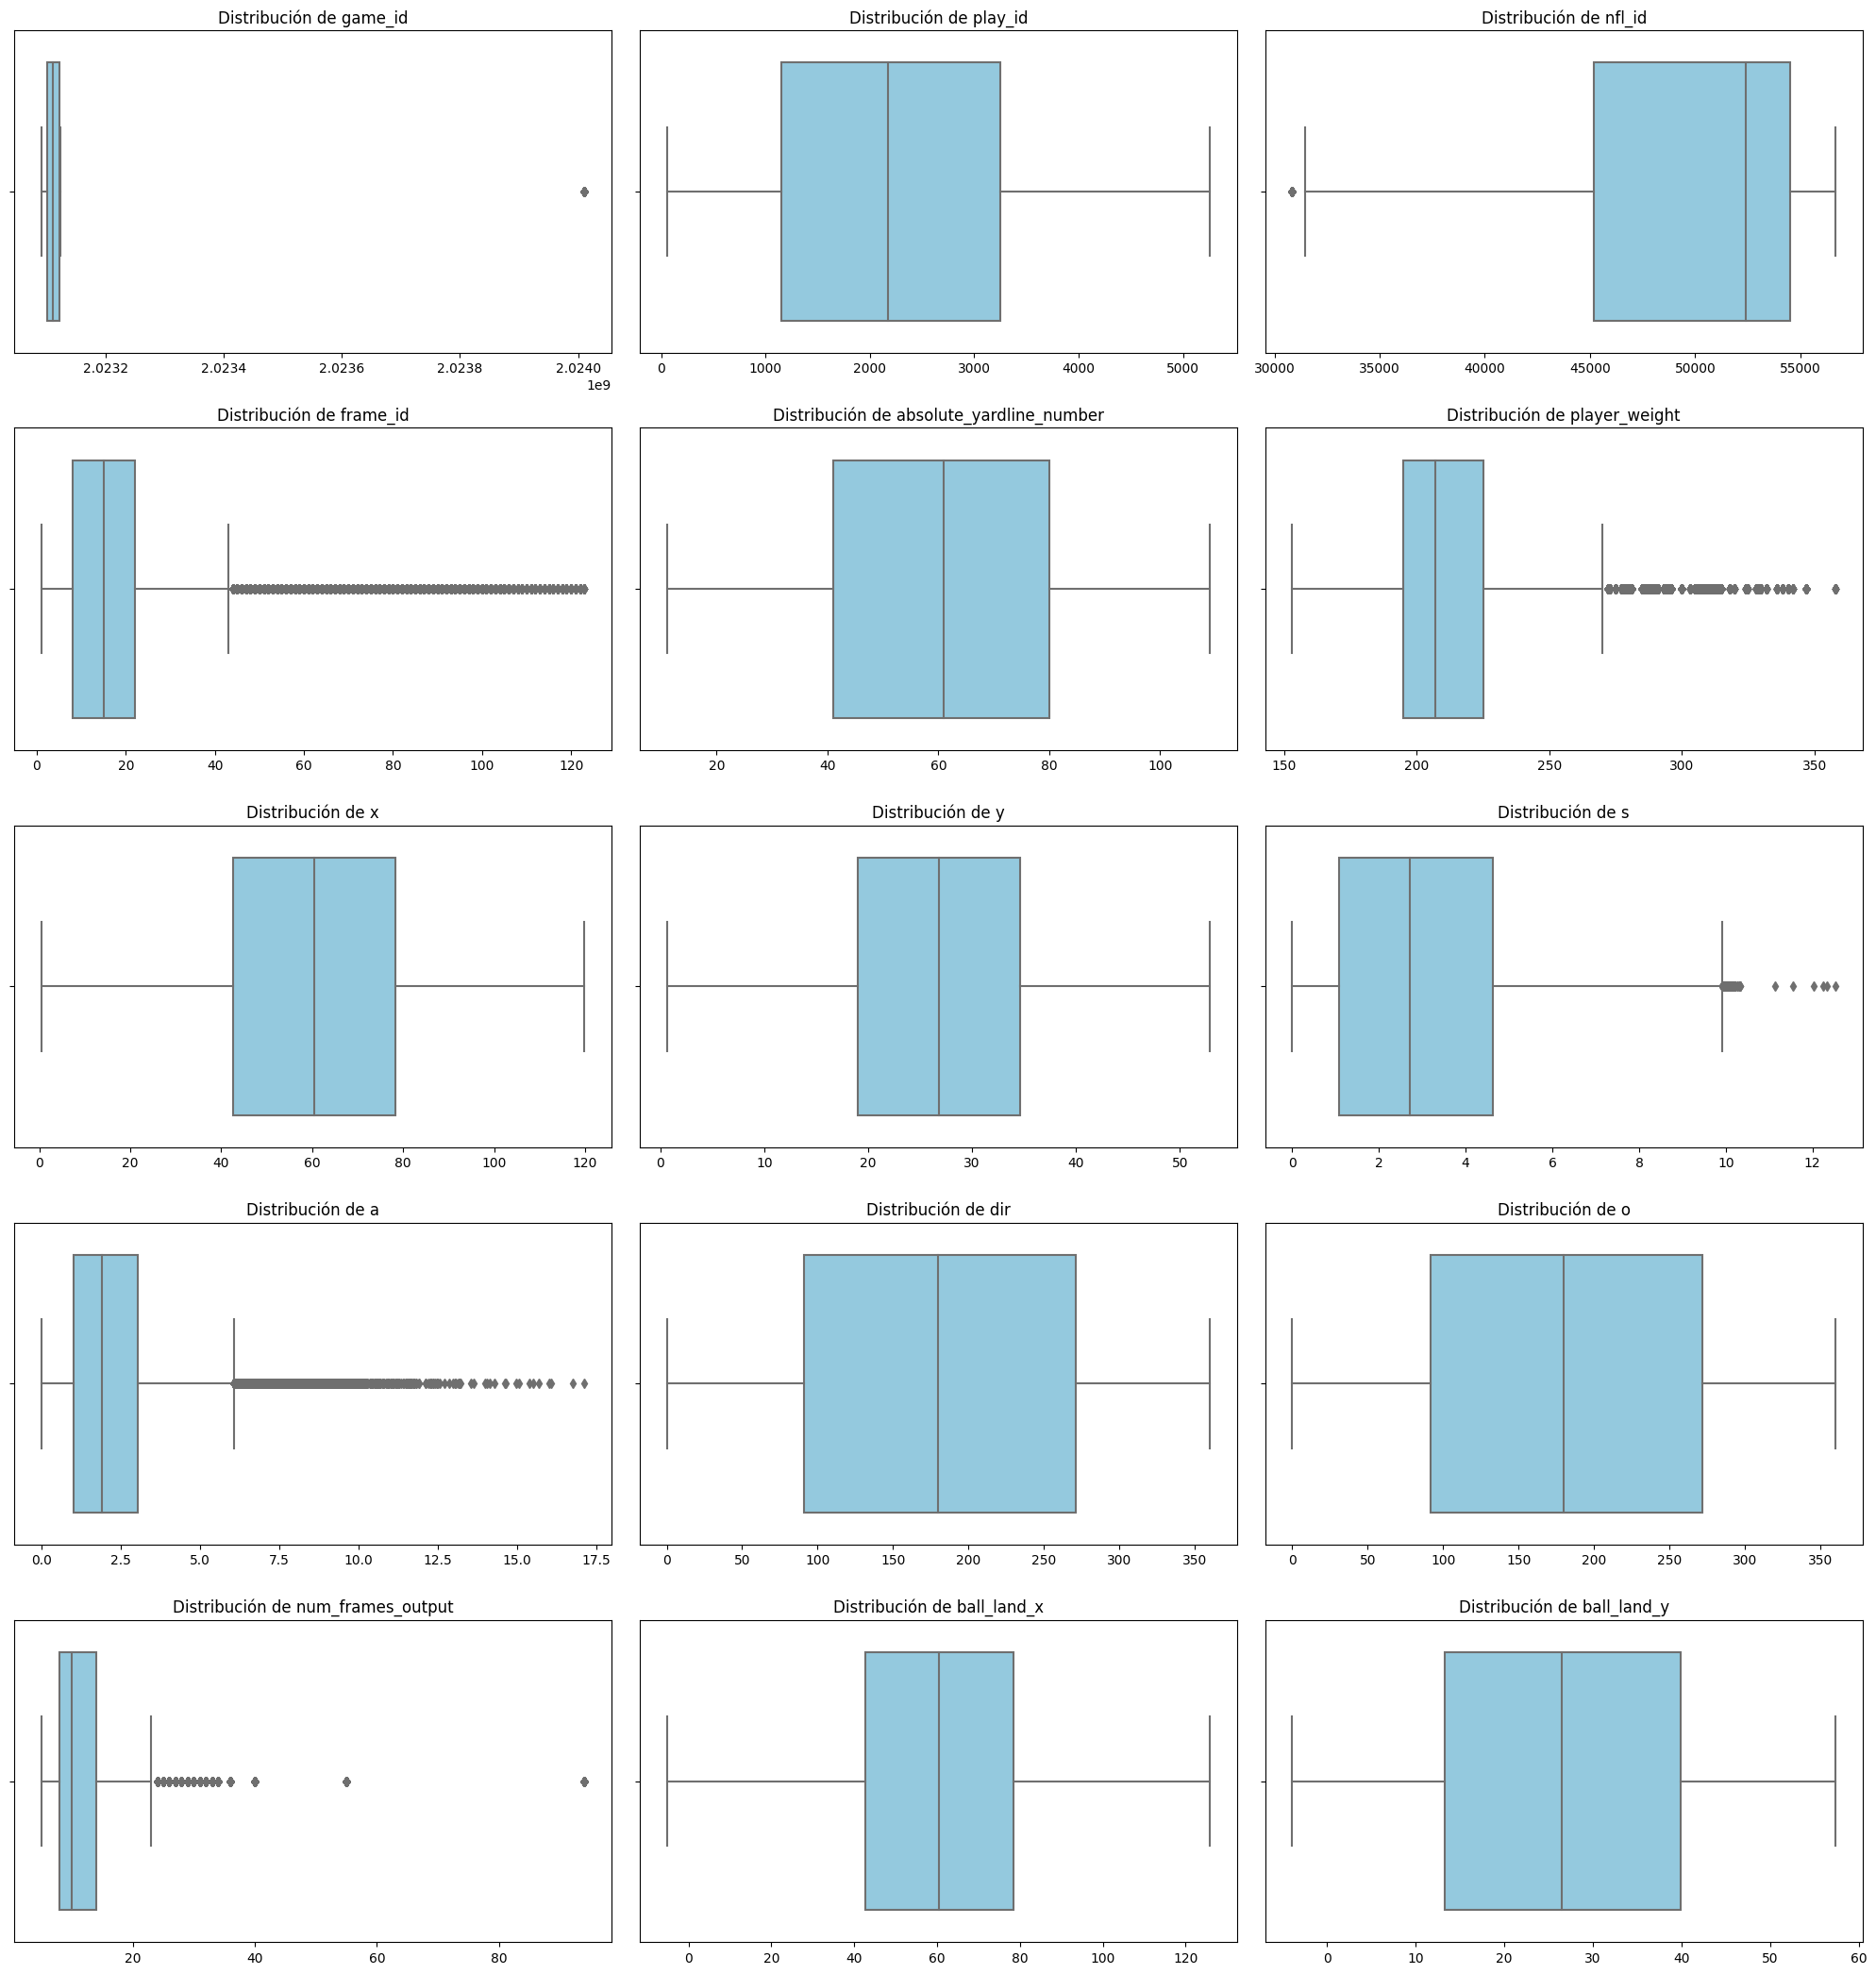

In [20]:
#boxplot para ver la distribucion de nuestros datos 

plt.figure(figsize=(20, 25))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols)//3 + 1, 3, i)
    sns.boxplot(x=train_df[col], color='skyblue')
    plt.title(f'Distribución de {col}', fontsize=12)
    plt.xlabel('')
plt.tight_layout()
plt.show()


### Analisis boxplot
1. **Identificadores:** game_id, play_id, frame_id
2. **Outliers:** player_wight,s,a
3. **Bimodal:** dir,o
4. **sin problema:** absolute_yardline_number, ball_land_x, ball_land_y

In [21]:
train_df['player_weight'].describe()


count    4.880579e+06
mean     2.112783e+02
std      2.217747e+01
min      1.530000e+02
25%      1.950000e+02
50%      2.070000e+02
75%      2.250000e+02
max      3.580000e+02
Name: player_weight, dtype: float64

In [22]:
train_df[['x','y']].describe()

,x,y
count,4.880579e+06,4.880579e+06
mean,6.050074e+01,2.681190e+01
std,2.348919e+01,1.000620e+01
min,4.100000e-01,6.200000e-01
25%,4.263000e+01,1.899000e+01
50%,6.041000e+01,2.685000e+01
75%,7.823000e+01,3.462000e+01
max,1.198600e+02,5.288000e+01


In [23]:
train_df[['s','a']].quantile([0.95, 0.99])


,s,a
0.95,7.08,4.74
0.99,8.22,5.81


In [24]:
missing = train_df.isnull().mean() * 100
missing[missing > 0].sort_values(ascending=False)


Series([], dtype: float64)

In [25]:
# Sesgo y curtosis/ para identificar distribucio real
skewness = train_df[["x", "y", "s", "a", "o", "dir", "player_weight"]].skew()
kurtosis = train_df[["x", "y", "s", "a", "o", "dir", "player_weight"]].kurt()

pd.DataFrame({"Sesgo": skewness, "Curtosis": kurtosis})


,Sesgo,Curtosis
x,0.012997,-0.668632
y,-0.004670,-0.790100
s,0.489582,-0.698358
a,0.636017,0.032648
o,-0.002102,-1.416443
dir,-0.000268,-1.300016
player_weight,0.621690,0.368460


### Analisis sesgo y curtosis
* **x:** platicurtica
* **y:** Simetrica
* **s:** Cola a la deracha
* **a:** Cola a la derecha
* **o:** Distribucion uniforme sobre angulos
* **dir:** Bimodal

“El análisis exploratorio evidencia que la mayoría de las variables presentan distribuciones simétricas con curtosis negativa, lo cual indica estabilidad y ausencia de valores extremos. Sin embargo, las variables s, a y player_weight muestran sesgo positivo, por lo que podrían beneficiarse de una transformación logarítmica para mejorar la normalidad en modelos paramétricos.”

### Creamos una copia de nuestra base de datos

trabajaremos con esta copia de ahora en adelante ya se le haran cambios y no queremos cambiar nuestra base datos real

In [26]:
# Crear una copia del DataFrame original
df_clean = train_df.copy()

In [27]:
df_clean.isnull().values.any()

False

In [28]:
df_clean.isnull().sum()


game_id                     0
play_id                     0
player_to_predict           0
nfl_id                      0
frame_id                    0
play_direction              0
absolute_yardline_number    0
player_name                 0
player_height               0
player_weight               0
player_birth_date           0
player_position             0
player_side                 0
player_role                 0
x                           0
y                           0
s                           0
a                           0
dir                         0
o                           0
num_frames_output           0
ball_land_x                 0
ball_land_y                 0
dtype: int64

### VALORES NAN

como pudimos ver, nuestra base de datos no cuenta con valores nulos

In [29]:
# Duplicados
duplicados = df_clean.duplicated().sum()
print(f'Duplicados encontrados: {duplicados}')

Duplicados encontrados: 0


In [30]:
z_scores = np.abs(stats.zscore(df_clean.select_dtypes(include=[np.number])))
outliers = (z_scores > 3).sum()
print('Cantidad de outliers por variable:\n', outliers)

Cantidad de outliers por variable:
 449505


In [31]:
outliers_por_variable = (z_scores > 3).sum(axis=0)
print(outliers_por_variable)


[254917      0   6097  59384      0  15495      0      0    546  18918
      0      0  94148      0      0]


In [32]:
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clean.dropna(subset=['x','y','s','a','o','dir','player_weight'], inplace=True)


TypeError: 'Series' object is not callable

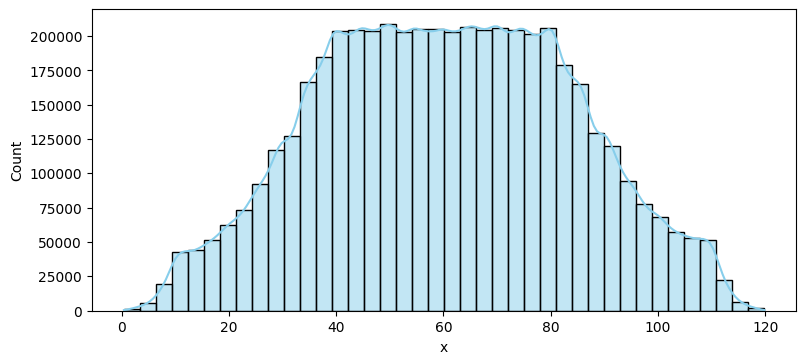

In [33]:
# Lista de variables a analizar
variables = ['x', 'y', 's', 'a', 'o', 'dir', 'player_weight']

# Crear una figura 
plt.figure(figsize=(20, 18))

for i, var in enumerate(variables, 1):
    plt.subplot(4, 2, i)
    sns.histplot(df_clean[var], bins=40, kde=True, color='skyblue')
    sesgo = skew(df_clean[var].dropna())
    curt = kurtosis(df_clean[var].dropna())
    plt.title(f'{var} | Sesgo: {sesgo:.3f} | Curtosis: {curt:.3f}', fontsize=12)
    plt.xlabel(var)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

### Transformacion de radianes a Sen y Cos

esto se hace para evitar errores de similitud entre radianes y gran diferencia numerica, como por ejemplo el 0 y 360 que estarian en la misma posicion pero numericamente muy alejados

In [34]:
#transformacion de radianes a sen y cos

#dir
df_clean['dir_rad'] = np.deg2rad(df_clean['dir'])
df_clean['dir_sin'] = np.sin(df_clean['dir_rad'])
df_clean['dir_cos'] = np.cos(df_clean['dir_rad'])

#o
df_clean['o_rad'] = np.deg2rad(df_clean['o'])
df_clean['o_sin'] = np.sin(df_clean['o_rad'])
df_clean['o_cos'] = np.cos(df_clean['o_rad'])

In [35]:
# percentiles para decidir umbral
df_clean['s'].quantile([0.90,0.95,0.99])
df_clean['a'].quantile([0.90,0.95,0.99])
df_clean['player_weight'].quantile([0.90,0.95,0.99])

# transformar/comprimir
df_clean['s_log1p'] = np.log1p(df_clean['s'])
df_clean['a_log1p'] = np.log1p(df_clean['a'])
df_clean['player_weight_log'] = np.log1p(df_clean['player_weight'])


### Normalizacion espacial

normalizaremos las jugadas en un solo sentido para reducir ruido y complejidad 

In [36]:
mask = df_clean['play_direction'] == 'left'
train_df.loc[mask, 'x'] = 120 - train_df.loc[mask, 'x']
train_df.loc[mask, 'y'] = 53.3 - train_df.loc[mask, 'y']


In [37]:
#revisar cantidad de categorias
cat_vars = ['player_position', 'player_side', 'player_role', 'play_direction']

for var in cat_vars:
    print(f"{var}: {df_clean[var].nunique()} categorías")
    print(df_clean[var].unique(), "\n")


player_position: 19 categorías
['FS' 'SS' 'CB' 'MLB' 'WR' 'TE' 'QB' 'OLB' 'ILB' 'RB' 'DE' 'FB' 'NT' 'DT'
 'S' 'T' 'LB' 'P' 'K'] 

player_side: 2 categorías
['Defense' 'Offense'] 

player_role: 4 categorías
['Defensive Coverage' 'Other Route Runner' 'Passer' 'Targeted Receiver'] 

play_direction: 2 categorías
['right' 'left'] 



### lista de columnas antes de codificar

In [38]:
print(df_clean.columns.tolist())

['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id', 'play_direction', 'absolute_yardline_number', 'player_name', 'player_height', 'player_weight', 'player_birth_date', 'player_position', 'player_side', 'player_role', 'x', 'y', 's', 'a', 'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y', 'dir_rad', 'dir_sin', 'dir_cos', 'o_rad', 'o_sin', 'o_cos', 's_log1p', 'a_log1p', 'player_weight_log']


In [39]:
# Label Encoding (para variables binarias)
label_vars = ['player_side', 'play_direction']
for col in label_vars:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])

# Verificación del resultado
print(train_df.shape)
train_df.head()


(4880579, 23)


,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.09,0.39,322.40,238.24,21,63.259998,-0.22
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.04,0.61,200.89,236.05,21,63.259998,-0.22
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.93,0.12,0.73,147.55,240.60,21,63.259998,-0.22
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.35,36.92,0.23,0.81,131.40,244.25,21,63.259998,-0.22
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.37,36.90,0.35,0.82,123.26,244.25,21,63.259998,-0.22


In [40]:
onehot_vars = ['player_position', 'player_role']

# Aplicar One-Hot Encoding solo si aún no está hecho
if not any(col.startswith('player_position_') for col in df_clean.columns):
    df_clean = pd.get_dummies(df_clean, columns=onehot_vars, drop_first=False)

print("Shape final después del One-Hot Encoding:", df_clean.shape)

# Verificación rápida
df_clean.filter(regex='player_position_|player_role_').head()

Shape final después del One-Hot Encoding: (4880579, 53)


,player_position_CB,player_position_DE,player_position_DT,player_position_FB,player_position_FS,player_position_ILB,player_position_K,player_position_LB,player_position_MLB,player_position_NT,...,player_position_RB,player_position_S,player_position_SS,player_position_T,player_position_TE,player_position_WR,player_role_Defensive Coverage,player_role_Other Route Runner,player_role_Passer,player_role_Targeted Receiver
0,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


### lista de columnas despues de codificar

In [41]:
print(df_clean.columns.tolist())

['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id', 'play_direction', 'absolute_yardline_number', 'player_name', 'player_height', 'player_weight', 'player_birth_date', 'player_side', 'x', 'y', 's', 'a', 'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y', 'dir_rad', 'dir_sin', 'dir_cos', 'o_rad', 'o_sin', 'o_cos', 's_log1p', 'a_log1p', 'player_weight_log', 'player_position_CB', 'player_position_DE', 'player_position_DT', 'player_position_FB', 'player_position_FS', 'player_position_ILB', 'player_position_K', 'player_position_LB', 'player_position_MLB', 'player_position_NT', 'player_position_OLB', 'player_position_P', 'player_position_QB', 'player_position_RB', 'player_position_S', 'player_position_SS', 'player_position_T', 'player_position_TE', 'player_position_WR', 'player_role_Defensive Coverage', 'player_role_Other Route Runner', 'player_role_Passer', 'player_role_Targeted Receiver']


In [42]:
# Convertir fecha de nacimiento a tipo datetime
df_clean['player_birth_date'] = pd.to_datetime(df_clean['player_birth_date'], errors='coerce') #coerce forza a los valores no validos

# Convertir altura de formato '6-2' (pies-pulgadas) a metros (versión vectorizada)
df_clean[['feet', 'inches']] = df_clean['player_height'].str.extract(r'(\d+)-(\d+)').astype(float)
df_clean['player_height_m'] = df_clean['feet'] * 0.3048 + df_clean['inches'] * 0.0254
df_clean.drop(columns=['feet', 'inches'], inplace=True)

# Edad del jugador (asumimos año 2025)
df_clean['player_age'] = 2025 - df_clean['player_birth_date'].dt.year # calculamos la edad 

# Índice de masa corporal (BMI)
df_clean['BMI'] = df_clean['player_weight'] / (df_clean['player_height_m'] ** 2)

# Componentes de velocidad (en yardas/s)
df_clean['velocity_x'] = df_clean['s'] * np.cos(np.deg2rad(df_clean['dir']))
df_clean['velocity_y'] = df_clean['s'] * np.sin(np.deg2rad(df_clean['dir']))

# Magnitud de aceleración
df_clean['acceleration_abs'] = df_clean['a'].abs()

In [43]:
# Selecciona solo las columnas numéricas originales
numeric_vars = ['absolute_yardline_number', 'player_weight', 'x', 'y', 's', 'a', 'dir', 'o',
                'num_frames_output', 'ball_land_x', 'ball_land_y']

# estandarizamos nuestros datos
scaler = StandardScaler()
df_clean[numeric_vars] = scaler.fit_transform(df_clean[numeric_vars])

In [44]:
# Seleccionar solo columnas numéricas
df_num = df_clean.select_dtypes(include=['int64', 'float64'])

# Calcular la matriz de correlación
corr_matrix = df_num.corr()

# Variables objetivo
targets = ['x', 'y']

# Mostrar correlación con cada objetivo
for target in targets:
    if target in corr_matrix.columns:
        print(f"\n🔹 Correlaciones con {target}:")
        display(corr_matrix[target].sort_values(ascending=False))



🔹 Correlaciones con x:


x                           1.000000
absolute_yardline_number    0.937889
ball_land_x                 0.859600
o                           0.131395
o_rad                       0.131395
dir_sin                     0.072572
velocity_y                  0.069998
play_direction              0.035077
o_cos                       0.021645
frame_id                    0.006850
game_id                     0.004195
BMI                         0.003471
player_weight               0.003312
player_weight_log           0.003124
a                           0.001613
acceleration_abs            0.001613
a_log1p                     0.001595
player_height_m             0.001023
nfl_id                      0.000225
player_side                -0.001039
s_log1p                    -0.001239
s                          -0.002098
y                          -0.005442
play_id                    -0.008586
velocity_x                 -0.009809
ball_land_y                -0.009878
dir_cos                    -0.010790
n


🔹 Correlaciones con y:


y                           1.000000
velocity_x                  0.270507
dir_cos                     0.253922
ball_land_y                 0.050480
o                           0.006594
o_rad                       0.006594
game_id                     0.002696
player_height_m             0.002592
player_weight               0.002333
frame_id                    0.002267
player_weight_log           0.001951
velocity_y                  0.001852
play_direction              0.001461
dir_sin                     0.000857
BMI                         0.000804
player_side                 0.000600
num_frames_output           0.000495
nfl_id                      0.000361
play_id                    -0.000180
dir                        -0.000736
dir_rad                    -0.000736
a_log1p                    -0.001446
a                          -0.001657
acceleration_abs           -0.001657
s_log1p                    -0.002071
s                          -0.002318
o_sin                      -0.003777
a

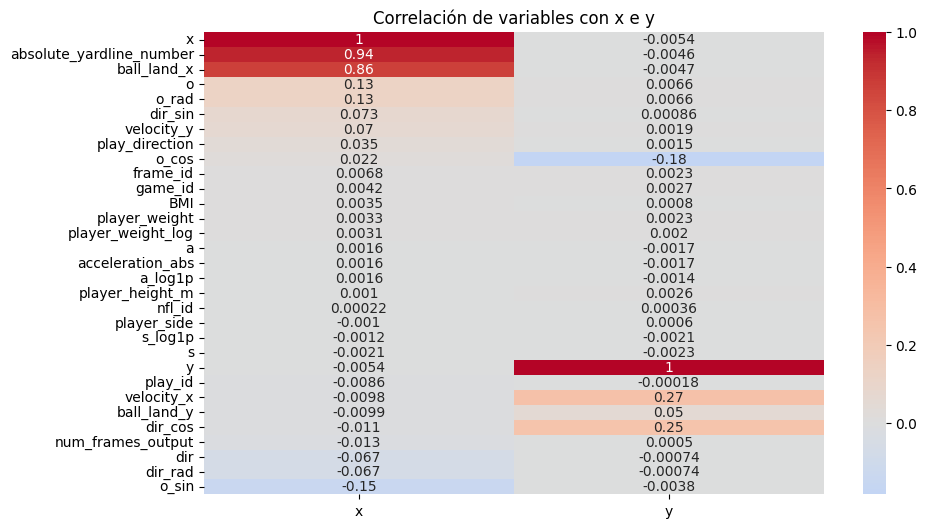

In [59]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix[['x', 'y']].sort_values(by='x', ascending=False),
            annot=True, cmap='coolwarm', center=0)
plt.title('Correlación de variables con x e y')
plt.show()


In [60]:
targets = ['x', 'y']
corr_mean = corr_matrix[targets].abs().mean(axis=1).sort_values(ascending=False)

print("🔸 Promedio de correlación absoluta con ambas salidas:")
display(corr_mean)


🔸 Promedio de correlación absoluta con ambas salidas:


y                           0.502721
x                           0.502721
absolute_yardline_number    0.471234
ball_land_x                 0.432142
velocity_x                  0.140158
dir_cos                     0.132356
o_cos                       0.102349
o_sin                       0.074773
o                           0.068995
o_rad                       0.068995
dir_sin                     0.036714
velocity_y                  0.035925
dir_rad                     0.033655
dir                         0.033655
ball_land_y                 0.030179
play_direction              0.018269
num_frames_output           0.006512
frame_id                    0.004559
play_id                     0.004383
game_id                     0.003446
player_weight               0.002823
player_weight_log           0.002537
s                           0.002208
BMI                         0.002138
player_height_m             0.001807
s_log1p                     0.001655
a                           0.001635
a

In [55]:
predictors = [
    'ball_land_x', 'ball_land_y', 'absolute_yardline_number',
    'velocity_x', 'velocity_y',
    'dir_cos', 'dir_sin', 'o_cos', 'o_sin',
    's', 'a', 'acceleration_abs',
    'BMI', 'player_height_m', 'player_weight_log',
    'num_frames_output'
]

targets = ['x', 'y']


In [ ]:
# ============================================================
# Optimización Bayesiana con Optuna - LightGBM y comparativa
# ============================================================
import optuna
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold
import numpy as np

def safe_mape(y_true, y_pred):
    eps = 1e-6
    denom = np.where(np.abs(y_true) < eps, eps, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

# --------------------------------------------
# Función objetivo (para LightGBM con Optuna)
# --------------------------------------------
def objective_lgb(trial, X, y):
    dtrain = lgb.Dataset(X, label=y)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'seed': 42
    }

    cv_results = lgb.cv(
        params=params,
        train_set=dtrain,
        folds=KFold(n_splits=3, shuffle=True, random_state=42),
        num_boost_round=100,
        callbacks=[lgb.early_stopping(10, verbose=False)],
    )

    rmse_key = [k for k in cv_results.keys() if 'rmse-mean' in k][0]
    return np.min(cv_results[rmse_key])

# --------------------------------------------
# Entrenamiento y evaluación final
# --------------------------------------------
def tune_and_train(X_train, y_train, X_val, y_val, n_trials=5):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda t: objective_lgb(t, X_train, y_train), n_trials=n_trials, show_progress_bar=True)

    best = study.best_params
    print("\n✅ Mejores hiperparámetros encontrados:")
    for k, v in best.items():
        print(f"   - {k}: {v}")

    # Entrenar modelo final
    model = lgb.LGBMRegressor(**best, objective='regression', n_estimators=300)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[lgb.log_evaluation(20), lgb.early_stopping(10)]
    )
    return model, study


# --------------------------------------------
# Evaluación con métricas solicitadas
# --------------------------------------------
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred),
        "MAPE": safe_mape(y_test, y_pred)
    }

# --------------------------------------------
# Ejecución para cada target
# --------------------------------------------
print("🔹 Optimizando LightGBM para X...")
model_x, study_x = tune_and_train(X_train, y_train[:, 0], X_val, y_val[:, 0])

print("\n🔹 Optimizando LightGBM para Y...")
model_y, study_y = tune_and_train(X_train, y_train[:, 1], X_val, y_val[:, 1])

# Evaluación final (hold-out 20%)
metrics_x = evaluate_model(model_x, X_test, y_test[:, 0])
metrics_y = evaluate_model(model_y, X_test, y_test[:, 1])

print("\n📊 Resultados finales en conjunto de evaluación:")
for name, val in zip(["x_target", "y_target"], [metrics_x, metrics_y]):
    print(f"\n🔸 {name.upper()}")
    for k, v in val.items():
        print(f"   {k}: {v:.4f}")


[I 2025-10-15 04:35:52,165] A new study created in memory with name: no-name-7e9baaa4-d123-4c56-acf5-81d6a62bd6c5


🔹 Optimizando LightGBM para X...


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-10-15 04:37:03,045] Trial 0 finished with value: 0.3633474620877128 and parameters: {'learning_rate': 0.012375392526208846, 'num_leaves': 43, 'feature_fraction': 0.9749786635530786, 'bagging_fraction': 0.8930574410299934, 'bagging_freq': 3, 'min_child_samples': 35}. Best is trial 0 with value: 0.3633474620877128.
[I 2025-10-15 04:37:50,797] Trial 1 finished with value: 0.1838294465964442 and parameters: {'learning_rate': 0.11966398429742449, 'num_leaves': 27, 'feature_fraction': 0.9442171084350912, 'bagging_fraction': 0.7396831071680027, 'bagging_freq': 7, 'min_child_samples': 49}. Best is trial 1 with value: 0.1838294465964442.
[I 2025-10-15 04:38:40,995] Trial 2 finished with value: 0.1753613501494589 and parameters: {'learning_rate': 0.19160787319424716, 'num_leaves': 49, 'feature_fraction': 0.9629687913600693, 'bagging_fraction': 0.868512015395428, 'bagging_freq': 7, 'min_child_samples': 31}. Best is trial 2 with value: 0.1753613501494589.
[I 2025-10-15 04:39:44,028] Trial 

[I 2025-10-15 04:41:45,238] A new study created in memory with name: no-name-5a9dca4e-ed53-4f97-b90b-8d0369fecfd6


[300]	valid_0's rmse: 0.163152	valid_0's l2: 0.0266187
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 0.163152	valid_0's l2: 0.0266187

🔹 Optimizando LightGBM para Y...


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-10-15 04:42:32,257] Trial 0 finished with value: 0.8424823270245071 and parameters: {'learning_rate': 0.12092844554698556, 'num_leaves': 83, 'feature_fraction': 0.8121027437218402, 'bagging_fraction': 0.8012555767840377, 'bagging_freq': 5, 'min_child_samples': 41}. Best is trial 0 with value: 0.8424823270245071.
[I 2025-10-15 04:43:03,516] Trial 1 finished with value: 0.86035420400246 and parameters: {'learning_rate': 0.191146403715522, 'num_leaves': 20, 'feature_fraction': 0.785309192595854, 'bagging_fraction': 0.815194205629663, 'bagging_freq': 1, 'min_child_samples': 46}. Best is trial 0 with value: 0.8424823270245071.
[I 2025-10-15 04:43:46,186] Trial 2 finished with value: 0.8585294856416281 and parameters: {'learning_rate': 0.1001900504838991, 'num_leaves': 37, 'feature_fraction': 0.8201866263964837, 'bagging_fraction': 0.7207263068096705, 'bagging_freq': 7, 'min_child_samples': 34}. Best is trial 0 with value: 0.8424823270245071.
